# Pre-processing Data



Import neccessary libralies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.datasets import load_boston

Load data

In [ ]:
boston = load_boston()
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data['MEDV'] = boston.target
X = df.iloc[:, :-1]
Y = df.iloc[:, -1:]

# Analyze and Visualize Data



Checking for missing values


In [ ]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [ ]:
data[data.isnull().any(axis=1)]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV



Calculate data statistics

In [ ]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Distribution of target 
> The value of the attribute price is in normal distribution




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


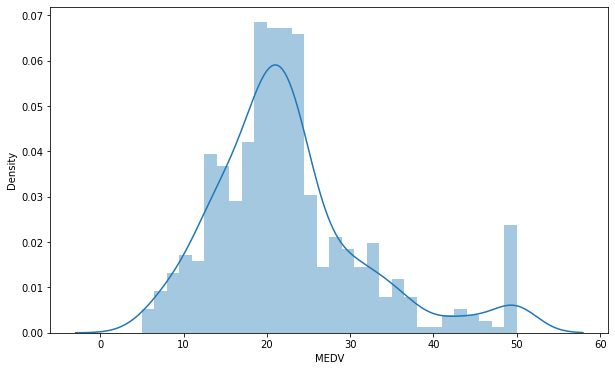

In [ ]:
plt.figure(figsize=(10, 6))
sns.distplot(Y['MEDV'],bins=30)

Correlation matrix
> The higher of the absolute correlataion value betweem two features, the more they depend on each other. Note that for the negative values, it means that they grow in opposite direction.

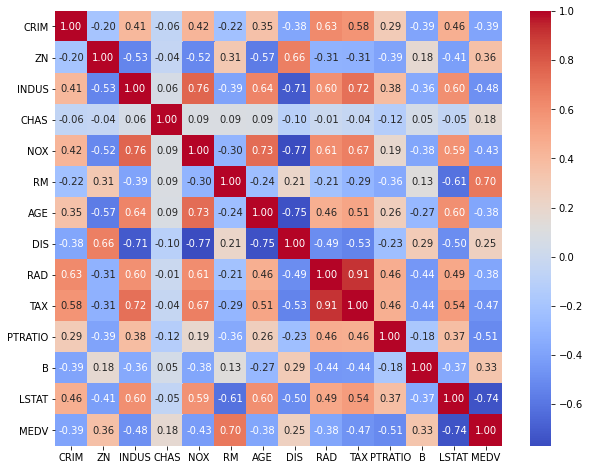

In [ ]:
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(data=corr_matrix,cmap='coolwarm',annot=True, fmt='.2f')

Relationships between features and target value

> The 'RM' and 'LSTAT' are in linear relationship with 'MEDV'


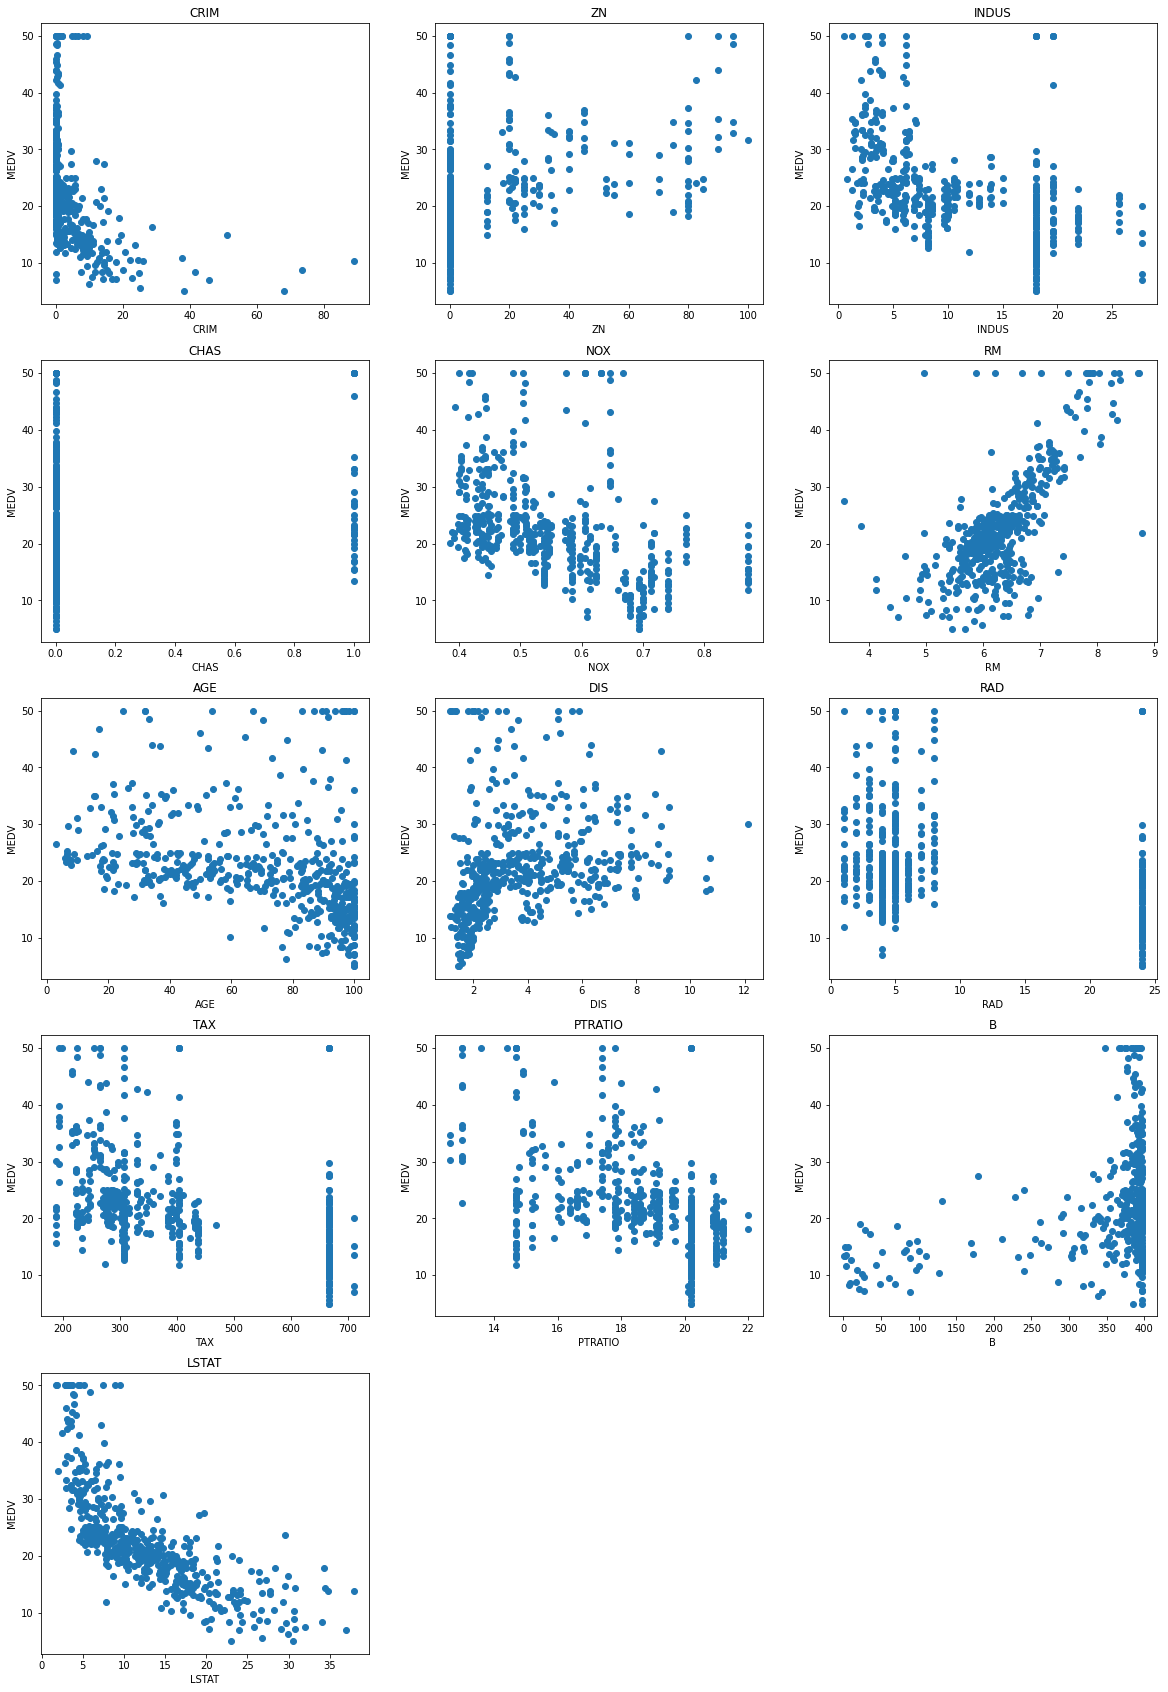

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 30))

for i, attribute in enumerate(X.columns):
    plt.subplot(5, 3, i+1)
    column = X[attribute]
    plt.plot(column, Y, 'o')
    plt.title(attribute)
    plt.xlabel(attribute)
    plt.ylabel('MEDV')

# Preparation

Split data into Training set and Testing set

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state=9)

In [ ]:
print(np.mean(Y_train['MEDV']))
print(np.mean(Y_test['MEDV']))
print(np.std(Y_train['MEDV']))
print(np.std(Y_test['MEDV']))

22.513366336633677
22.60980392156863
8.954570134380539
10.05917306276472


Choose performance evaluation
> Here we choose the coefficient of determination and Root-Mean-Square Deviation







In [ ]:
def r2(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    return score

def rmse(y_true, y_predict):
  return np.sqrt(metrics.mean_squared_error(y_true, y_predict))

def performance_evaluate(Y_true, Y_predicted):
  print('R_2:', r2(Y_true, Y_predicted))
  print('RMSE: ', rmse(Y_true, Y_predicted))

# Decision Tree

## Create baseline

In [ ]:
regressor_tree = DecisionTreeRegressor(random_state = 5) 
regressor_tree.fit(X_train, Y_train)
print("Train:")
Y_pred = regressor_tree.predict(X_train)
performance_evaluate(Y_true=Y_train,Y_predicted=Y_pred)
print("Test:")
Y_pred = regressor_tree.predict(X_test)
performance_evaluate(Y_true=Y_test,Y_predicted=Y_pred)

Train:
R_2: 1.0
RMSE:  0.0
Test:
R_2: 0.7223466224375805
RMSE:  5.30046242895696


## Feature Importance

In [ ]:
def feature_importance(model, x_train):
  importance = model.feature_importances_ 
  feature_importance = pd.DataFrame(importance, index=x_train.columns, columns=['Importance'])
  return feature_importance.sort_values(by=['Importance'], ascending=False)

In [ ]:
feat_importance_rt =feature_importance(regressor_tree, X_train)
feat_importance_rt

,Importance
RM,0.552241
LSTAT,0.208174
DIS,0.080686
CRIM,0.078694
TAX,0.025027
AGE,0.015555
NOX,0.010391
PTRATIO,0.008983
INDUS,0.008359
B,0.005533


### Discard features that have importance < 0.01


In [ ]:
features_rt = feat_importance_rt[feat_importance_rt['Importance'] >= 0.01].index
print(features_rt)

Index(['RM', 'LSTAT', 'DIS', 'CRIM', 'TAX', 'AGE', 'NOX'], dtype='object')


## Hyperparameter Tunning

We differs important hyperparameters:
1. max_depth: the maximum depth of the tree


In [ ]:
def fit_model_rt(X, y):
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    regressor = DecisionTreeRegressor(random_state=5)
    params = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
            }
    scoring_fnc = make_scorer(r2)
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets, verbose= False)
    grid = grid.fit(X, y)
    return grid.best_estimator_

In [ ]:
rt = fit_model_rt(X_train[features_rt], Y_train)

Get the best hyperparameters:
1. max_depth: 5

In [ ]:
print(rt.get_params())

{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 5, 'splitter': 'best'}


## Final Model and Evaluation

In [ ]:
dec_tree = DecisionTreeRegressor(random_state=5, max_depth=5)
dec_tree.fit(X_train[features_rt], Y_train)
print("Train:")
Y_pred = dec_tree.predict(X_train[features_rt])
performance_evaluate(Y_true=Y_train,Y_predicted=Y_pred)
print("Test:")
Y_pred = dec_tree.predict(X_test[features_rt])
performance_evaluate(Y_true=Y_test,Y_predicted=Y_pred)

Train:
R_2: 0.9178234870931828
RMSE:  2.5669570164732356
Test:
R_2: 0.8518682372774256
RMSE:  3.8715633987162943


# Random Forest

## Create baseline

In [ ]:
#random_state=5
rf = RandomForestRegressor(random_state=5)
rf.fit(X_train, Y_train)
print("Train:")
Y_pred = rf.predict(X_train)
performance_evaluate(Y_true=Y_train,Y_predicted=Y_pred)
print("Test:")
Y_pred = rf.predict(X_test)
performance_evaluate(Y_true=Y_test,Y_predicted=Y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Train:
R_2: 0.9774104834187783
RMSE:  1.3458548095232379
Test:
R_2: 0.883431384522786
RMSE:  3.4344175848400886


## Feature Importance

In [ ]:
feat_importance=feature_importance(rf, X_train)
feat_importance

,Importance
RM,0.468967
LSTAT,0.320852
DIS,0.061337
CRIM,0.049608
NOX,0.029972
AGE,0.016891
TAX,0.014190
PTRATIO,0.014029
B,0.012265
INDUS,0.006390


https://mljar.com/blog/feature-importance-in-random-forest/#:~:text=Random%20Forest%20Built%2Din%20Feature,a%20set%20of%20Decision%20Trees.

### Discard features that have importance < 0.01


In [ ]:
features = feat_importance[feat_importance['Importance'] > 0.01].index
features

Index(['RM', 'LSTAT', 'DIS', 'CRIM', 'NOX', 'AGE', 'TAX', 'PTRATIO', 'B'], dtype='object')

## Hyperparameter Tunning

We differs important hyperparameters:


1.   n_estimators: number of trees
2.   max_features: number of features to consider when looking for the best split
3.   min_samples_leaf: minimum number of samples required to be at a leaf node



Build a tunning function

In [ ]:

def fit_model(X, y):
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    regressor = RandomForestRegressor()
    params = {'n_estimators': [int(x) for x in range(10, 1000, 100)],
            'max_features': [0.5,'auto', 'sqrt','log2'],
            'min_samples_leaf':[1, 2, 4]}
    scoring_fnc = make_scorer(r2)
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)
    grid = grid.fit(X, y)
    return grid.best_estimator_

Check the current features

In [ ]:
features

Index(['RM', 'LSTAT', 'DIS', 'CRIM', 'NOX', 'TAX', 'AGE', 'PTRATIO', 'B'], dtype='object')

Get the best hyperparameters


> n_estimators = 710, max_features = 0.5, min_sample_leaf = 1



In [ ]:
reg = fit_model(X_train[features], Y_train)
print(reg.get_params())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 710, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


## Final Model and Evaluation

In [ ]:
random_forest = RandomForestRegressor(max_features=0.5,min_samples_leaf=1,n_estimators=710, random_state=5)
random_forest.fit(X_train[features], Y_train)
print("Train:")
Y_pred = random_forest.predict(X_train[features])
performance_evaluate(Y_true=Y_train,Y_predicted=Y_pred)
print("Test:")
Y_pred = random_forest.predict(X_test[features])
performance_evaluate(Y_true=Y_test,Y_predicted=Y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train:
R_2: 0.9818562452618306
RMSE:  1.2061694533020864
Test:
R_2: 0.9017950880261946
RMSE:  3.1523097508816327


# XGBoost

## Create baseline

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, Y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_test, Y_test)])
print("Train:")
Y_pred = xgb.predict(X_train)
performance_evaluate(Y_true=Y_train,Y_predicted=Y_pred)
print("Test:")
Y_pred = xgb.predict(X_test)
performance_evaluate(Y_true=Y_test,Y_predicted=Y_pred)

[08:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:22.0099
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:19.9444
[2]	validation_0-rmse:18.1227
[3]	validation_0-rmse:16.4447
[4]	validation_0-rmse:14.9208
[5]	validation_0-rmse:13.5939
[6]	validation_0-rmse:12.3677
[7]	validation_0-rmse:11.255
[8]	validation_0-rmse:10.2864
[9]	validation_0-rmse:9.44532
[10]	validation_0-rmse:8.66528
[11]	validation_0-rmse:8.01852
[12]	validation_0-rmse:7.41152
[13]	validation_0-rmse:6.90139
[14]	validation_0-rmse:6.43575
[15]	validation_0-rmse:6.03818
[16]	validation_0-rmse:5.68019
[17]	validation_0-rmse:5.41477
[18]	validation_0-rmse:5.13104
[19]	validation_0-rmse:4.90942
[20]	validation_0-rmse:4.72238
[21]	validation_0-rmse:4.55214
[22]	validation_0-rmse:4.4165
[23]	validation_0-rmse:4.32346
[24]	validation_0-rmse:4.19752
[25]	validation_0-rmse:4.11404
[26]	validatio

## Feature Importance

In [ ]:
def feature_importance(xg, x_train):
  importance = xg.feature_importances_ #average gain
  feature_importance = pd.DataFrame(importance, index=x_train.columns, columns=['Importance'])
  return feature_importance.sort_values(by=['Importance'], ascending=False)
feat_importance_xgb=feature_importance(xgb, X_train)
feat_importance_xgb

,Importance
LSTAT,0.384160
RM,0.323856
NOX,0.081430
DIS,0.048196
PTRATIO,0.041474
TAX,0.027951
CRIM,0.026610
B,0.019664
AGE,0.015012
CHAS,0.010134


### Discard features that have importance score < 0.01

In [ ]:
features_xgb = feat_importance_xgb[feat_importance_xgb['Importance'] >= 0.01].index
features_xgb

Index(['LSTAT', 'RM', 'NOX', 'DIS', 'PTRATIO', 'TAX', 'CRIM', 'B', 'AGE',
       'CHAS'],
      dtype='object')

## Hyperparameter Tunning

We differs important hyperparameters:


1.   learning rate: eta - step size shrinkage used in update to prevents overfitting
2.   gamma: minimum loss reduction required to make a further partition on a leaf node of the tree
3.   max_depth: maximum depth of a tree

In [ ]:
def fit_model_xgb(X, y):
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    regressor = XGBRegressor()
    params = {'learning_rate': [x/100 for x in range(1, 21, 2)],
            'gamma': [x/10 for x in range(0, 1, 1)],
            'max_depth':[int(x) for x in range(5, 11, 1)]
            }
    scoring_fnc = make_scorer(r2)
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets, verbose= False)
    grid = grid.fit(X, y)
    return grid.best_estimator_

In [ ]:
xg = fit_model_xgb(X_train[features_xgb], Y_train)

Get the best hyperparameters


1. learning_rate = 0.09
2. gamma = 0.0
3. max_depth = 5

In [ ]:
print(xg.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.0, 'importance_type': 'gain', 'learning_rate': 0.09, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}


## Final Model and Evaluation

In [ ]:
xgb1 = XGBRegressor(learning_rate=0.09, max_depth=5)
xgb1.fit(X_train[features_xgb], Y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_train[features_xgb], Y_train),(X_test[features_xgb], Y_test)])

In [ ]:
print("Train:")
Y_pred = xgb1.predict(X_train[features_xgb])
performance_evaluate(Y_true=Y_train,Y_predicted=Y_pred)
print("Test:")
Y_pred = xgb1.predict(X_test[features_xgb])
performance_evaluate(Y_true=Y_test,Y_predicted=Y_pred)

Train:
R_2: 0.9880389969420258
RMSE:  0.9793288375079693
Test:
R_2: 0.9061689085570779
RMSE:  3.081311920361091
